# Target

1. Use Image Augmentation to improve test accuracy further. Also, use LR Scheduler to fasten up convergence (quickly lower loss and improve accuracy). 

2. Keep the model & architecture same as previous Notebook.  

# Results

Total Parameters: 9910

Best Training Accuracy: 98.94

Best Test Accuracy: 99.37

# Analysis

1. Model's test accuracy has dropped marginally. Unable to explain why this is the case. 

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 12, kernel_size=3, padding=0), # RF 3
            BatchNorm2d(12),           
            ReLU(inplace=True),
            nn.Dropout(0.1),            

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 5
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.1),            

            Conv2d(12, 16, kernel_size=3, padding=0), # RF 7
            BatchNorm2d(16),             
            ReLU(inplace=True),
            nn.Dropout(0.1),                  

            MaxPool2d(kernel_size=2), # RF 8
            
            # Conv2d(16, 14, kernel_size=1, padding=0),
            # BatchNorm2d(14),             
            # ReLU(inplace=True),
            # nn.Dropout(0.1),            

            Conv2d(16, 16, kernel_size=3, padding=0), # RF 12
            BatchNorm2d(16),             
            ReLU(inplace=True),
            nn.Dropout(0.1),            
            
            Conv2d(16, 12, kernel_size=3, padding=0), # RF 16
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.1),

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 20
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.1),            

            Conv2d(12, 10, kernel_size=3, padding=0), # RF 24
            BatchNorm2d(10),             
            ReLU(inplace=True),
            nn.Dropout(0.1),

            nn.AdaptiveAvgPool2d((1,1)), # RF 28
            Conv2d(10, 10, kernel_size=1, bias = False) # RF 28

        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,744
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.05340907350182533 Batch_id=468 Accuracy=83.68: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9822/10000 (98.22%)

EPOCH: 1


Loss=0.07840768247842789 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9839/10000 (98.39%)

EPOCH: 2


Loss=0.1368972510099411 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.11671306937932968 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.053192559629678726 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.027411172166466713 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.033946339040994644 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.019322464242577553 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.11446163803339005 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.03996587172150612 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9893/10000 (98.93%)

EPOCH: 10


Loss=0.018237411975860596 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.002919897437095642 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.04517391696572304 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.01985967718064785 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.022651055827736855 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.0230, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

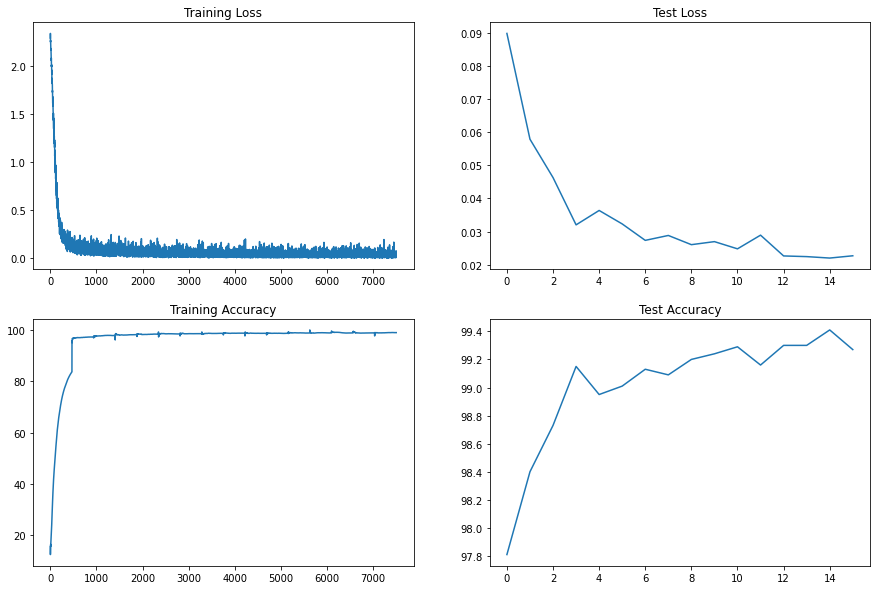

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")